In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Parameter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as opt
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR, ExponentialLR

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage import measure
from scipy.special import binom
from PIL import Image

import cv2
import random
import os
import math
import time
import datetime
import warnings

In [2]:
# Configuration

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
pd.set_option('display.max_colwidth', 200)

# files path
image_path = "CUB_200_2011/images"

train = pd.read_csv('PATH/train.csv')
test = pd.read_csv('PATH/test.csv')

In [3]:
class CUB200(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        
        label = self.df.Label.values[idx]
        filename = self.df.filename.values[idx]
        
        p_path = os.path.join(image_path, filename)
        
        image = cv2.imread(p_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([transforms.Resize((600, 600), Image.BILINEAR),
                                      transforms.RandomCrop((448, 448)),
                                      transforms.Resize((448, 448), Image.BILINEAR),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([transforms.Resize((448, 448), Image.BILINEAR),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean, std)
])


trainset = CUB200(train, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=24, shuffle=True, num_workers=4)

testset = CUB200(test, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=24, shuffle=False, num_workers=4)

In [5]:
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # self.conv2 = nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=4, stride=1,bias=False)
        # self.conv3 = nn.Conv2d(in_channels=2048, out_channels=201, kernel_size=1, stride=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.mpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        conv5_b = self.layer4[:2](x)
        x = self.layer4[2](conv5_b)

        fm = x
        x = self.mpool(x)
        x = x.view(x.size(0), -1)
        embeeding = x

        return fm, embeeding, conv5_b


def _resnet(arch, block, layers, pretrained, pth_path, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = torch.load(pth_path)
        model.load_state_dict(state_dict)
    return model

def resnet50(pth_path, pretrained=False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, pth_path, **kwargs)

In [6]:
class AdaptiveAM(nn.Module):
    def __init__(self, in_feat, out_feat, s=30.0, m1=0.50):
        super(AdaptiveAM, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.s = s
        self.m1 = m1
        self.weight = Parameter(torch.FloatTensor(out_feat, in_feat))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label, epoch):
        #---------------------------- Margin Additional -----------------------------
        if epoch <= 20:
            m1 = self.m1
        elif epoch > 20 and epoch <= 40:
            m1 = self.m1 + 0.25
        else:
            m1 = self.m1 + 0.5
        
        cos_m, sin_m = math.cos(m1), math.sin(m1)
        th = math.cos(math.pi - m1)
        mm = math.sin(math.pi - m1) * m1
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(0, 1))
        phi = cosine * cos_m - sine * sin_m
        phi = torch.where(cosine > th, phi, torch.zeros(1).to(device))
        # --------------------------- convert label to one-hot ---------------------------
        one_hot = torch.zeros(cosine.size()).to(device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  
        output *= self.s

        return self.s * cosine, output

In [7]:
def AOLM(fms, fm1):
    A = torch.sum(fms, dim=1, keepdim=True)
    a = torch.mean(A, dim=[2, 3], keepdim=True)
    M = (A > a).float()

    A1 = torch.sum(fm1, dim=1, keepdim=True)
    a1 = torch.mean(A1, dim=[2, 3], keepdim=True)
    M1 = (A1 > a1).float()

    coordinates = []
    for i, m in enumerate(M):
        mask_np = m.cpu().numpy().reshape(14, 14)
        component_labels = measure.label(mask_np)

        properties = measure.regionprops(component_labels)
        areas = []
        for prop in properties:
            areas.append(prop.area)
        max_idx = areas.index(max(areas))


        intersection = ((component_labels==(max_idx+1)).astype(int) + (M1[i][0].cpu().numpy()==1).astype(int)) ==2
        prop = measure.regionprops(intersection.astype(int))
        if len(prop) == 0:
            bbox = [0, 0, 14, 14]
            print('there is one img no intersection')
        else:
            bbox = prop[0].bbox

        x_lefttop = bbox[0] * 32 - 1
        y_lefttop = bbox[1] * 32 - 1
        x_rightlow = bbox[2] * 32 - 1
        y_rightlow = bbox[3] * 32 - 1
        # for image
        if x_lefttop < 0:
            x_lefttop = 0
        if y_lefttop < 0:
            y_lefttop = 0
        coordinate = [x_lefttop, y_lefttop, x_rightlow, y_rightlow]
        coordinates.append(coordinate)
    return coordinates

In [8]:
pretrain_path = 'PATH/resnet50-19c8e357.pth'

class MainNet(nn.Module):
    def __init__(self, num_classes, channels):
        super(MainNet, self).__init__()
        self.num_classes = num_classes
        self.pretrained_model = resnet50(pretrained=True, pth_path=pretrain_path)

    def forward(self, x):
        fm, embedding, conv5_b = self.pretrained_model(x)
        batch_size, channel_size, side_size, _ = fm.shape
        assert channel_size == 2048

        #SCDA
        coordinates = torch.tensor(AOLM(fm.detach(), conv5_b.detach()))

        local_imgs = torch.zeros([batch_size, 3, 448, 448]).to(device)  # [N, 3, 448, 448]
        for i in range(batch_size):
            [x0, y0, x1, y1] = coordinates[i]
            local_imgs[i:i + 1] = F.interpolate(x[i:i + 1, :, x0:(x1+1), y0:(y1+1)], size=(448, 448),
                                                mode='bilinear', align_corners=True)  # [N, 3, 224, 224]
        local_fm, local_embeddings, _ = self.pretrained_model(local_imgs.detach())  # [N, 2048]

        return embedding, local_embeddings
    
class Dense(nn.Module):

    def __init__(self):
        super(Dense, self).__init__()

        self.bn1 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 600)

    def forward(self, raw_em, local_em):

        raw_em = self.bn1(raw_em)
        raw_em = self.fc1(raw_em)
        raw_em = nn.ELU(inplace=True)(raw_em)
        
        local_em = self.bn1(local_em)
        local_em = self.fc1(local_em)
        local_em = nn.ELU(inplace=True)(local_em)

        return raw_em, local_em

In [9]:
tune_lr = 0.001
base_lr = 0.01
weight_decay = 1e-4
num_classes = 200

class EIE(nn.Module):
    def __init__(self, num_classes, device):
        super(EIE, self).__init__()
        
        self.model = MainNet(num_classes, 2048).to(device)
        self.Dense = Dense().to(device)
        self.Arcraw = AdaptiveAM(600, num_classes, s=16, m1=0).to(device)
        self.Arclocal = AdaptiveAM(600, num_classes, s=16, m1=0).to(device)
        
    def forward(self, inputs, labels, epoch):

        raw_em, local_em = self.model(inputs)
        raw_logit, local_logit = self.Dense(raw_em, local_em)
        _, output1 = self.Arcraw(raw_logit, labels, epoch)
        logit, output2 = self.Arclocal(local_logit, labels, epoch)
        
        return logit, output1, output2
    
EIE_model_resnet50 = EIE(num_classes, device)

In [10]:
# model = MainNet(num_classes, 2048).to(device)
# Dense = Dense().to(device)
# Arcraw = AdaptiveAM(600, num_classes, s=16, m1=0).to(device)
# Arclocal = AdaptiveAM(600, num_classes, s=16, m1=0).to(device)

criterion = nn.CrossEntropyLoss()

Extraction_opt = opt.SGD(EIE_model_resnet50.model.parameters(), lr=tune_lr, momentum=0.9, weight_decay=weight_decay, nesterov=True)
# Extraction_scheduler = ReduceLROnPlateau(Extraction_opt, mode='max', factor=0.1, patience=3, min_lr=1e-5, verbose=True)
Dense_opt = opt.SGD([{'params': EIE_model_resnet50.Dense.parameters()}, {'params': EIE_model_resnet50.Arcraw.parameters()}, {'params': EIE_model_resnet50.Arclocal.parameters()}], 
                    lr=base_lr, 
                    momentum=0.9, 
                    weight_decay=weight_decay, 
                    nesterov=True)

Extraction_scheduler = MultiStepLR(Extraction_opt, milestones=[40], gamma=0.1)
Dense_scheduler = MultiStepLR(Dense_opt, milestones=[30, 50], gamma=0.1)

In [11]:
epochs = 70
save_model_path = 'Checkpoint'
steps = 0
running_loss = 0

print('Start fine-tuning...')
best_acc = 0.
best_epoch = None

for epoch in range(1, 1+epochs):
    
    start_time = time.time()
    for idx, data in enumerate(train_loader):
        steps += 1
        
        # Move input and label tensors to the default device
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        Extraction_opt.zero_grad()
        Dense_opt.zero_grad()
        
        _, output1, output2 = EIE_model_resnet50(inputs, labels, epoch)
        loss = criterion(output2, labels) + criterion(output1, labels)

        loss.backward()
        Extraction_opt.step()
        Dense_opt.step()

        running_loss += loss.item()
    stop_time = time.time()
    print('Epoch {}/{} and used time: {:.2f} sec.'.format(epoch, epochs, stop_time - start_time))
    
    # model.eval(), Arcraw.eval(), Arclocal.eval(), Dense.eval()
    EIE_model_resnet50.eval()
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        _loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in loader:
                
                imgs, labels = data
                imgs, labels = imgs.to(device), labels.to(device)
                
                logit, output1, output2 = EIE_model_resnet50(imgs, labels, epoch)
                loss = criterion(output2, labels) + criterion(output1, labels)
                _loss += loss.item()
                
                result = F.softmax(logit, dim=1)
                _, predicted = torch.max(result, dim=1)
                
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
            _acc = 100 * correct  / total
            _loss = _loss / len(loader)
            
        print('{} loss: {:.4f}    {} accuracy: {:.4f}'.format(name, _loss, name, _acc))
    print()
    
    running_loss = 0
    # model.train(), Arcraw.train(), Arclocal.train(), Dense.train()
    EIE_model_resnet50.train()
    Extraction_scheduler.step(_acc)
    Dense_scheduler.step()
    
    if _acc > best_acc:
#         model_file = os.path.join(save_model_path, 'resnet34_CUB_200_fine_tuning_epoch_{}_acc_{}.pth'.format(best_epoch, best_acc))
        
#         if os.path.isfile(model_file):
#             os.remove(os.path.join(save_model_path, 'resnet34_CUB_200_fine_tuning_epoch_{}_acc_{}.pth'.format(best_epoch, best_acc)))
        
        best_acc = _acc
        best_epoch = epoch
#         print('The accuracy is improved, save model')
#         torch.save(model.state_dict(), os.path.join(save_model_path,'resnet34_CUB_200_fine_tuning_epoch_{}_acc_{}.pth'.format(best_epoch, best_acc)))
print('After the training, the end of the epoch {}, the highest accuracy is {:.2f}'.format(best_epoch, best_acc))

Start fine-tuning...
Epoch 1/70 and used time: 160.32 sec.
train loss: 1.8432    train accuracy: 82.6326
test loss: 2.4661    test accuracy: 73.8350



/root/miniconda3/envs/myenv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/70 and used time: 160.93 sec.
train loss: 0.8982    train accuracy: 92.3423
test loss: 1.7061    test accuracy: 81.6534

Epoch 3/70 and used time: 160.25 sec.
train loss: 0.6022    train accuracy: 95.4621
test loss: 1.5230    test accuracy: 83.6037

Epoch 4/70 and used time: 160.51 sec.
train loss: 0.4361    train accuracy: 96.8302
test loss: 1.4574    test accuracy: 83.7763

Epoch 5/70 and used time: 160.83 sec.
train loss: 0.3234    train accuracy: 98.2316
test loss: 1.3925    test accuracy: 84.5702

Epoch 6/70 and used time: 160.79 sec.
train loss: 0.2577    train accuracy: 98.9156
test loss: 1.3772    test accuracy: 84.6048

there is one img no intersection
Epoch 7/70 and used time: 160.25 sec.
train loss: 0.2070    train accuracy: 99.3660
test loss: 1.3572    test accuracy: 84.7256

Epoch 8/70 and used time: 160.20 sec.
train loss: 0.1786    train accuracy: 99.0824
test loss: 1.3541    test accuracy: 84.5185

Epoch 9/70 and used time: 160.90 sec.
train loss: 0.1527    trai

In [12]:
# After the training, the end of the epoch 65, the highest accuracy is 88.28

In [82]:
to_save = EIE_model_resnet50.model.pretrained_model
PATHs = 'EIE_visual_rs50.pth'
torch.save(to_save, PATHs)

In [67]:
to_save2 = EIE_model_resnet50.Dense
PATHs = 'EIE_visual_dense.pth'
torch.save(to_save2, PATHs)

In [68]:
to_save3 = EIE_model_resnet50.Arcraw
PATHs = 'EIE_visual_arcraw.pth'
torch.save(to_save3, PATHs)

In [69]:
to_save4 = EIE_model_resnet50.Arclocal
PATHs = 'EIE_visual_arclocal.pth'
torch.save(to_save4, PATHs)

In [83]:
a = torch.load('EIE_visual_rs50.pth')
a

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [84]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

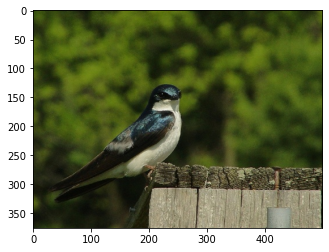

In [306]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([# transforms.Resize((600, 600)),
                                      # transforms.RandomCrop((448, 448)),
                                      transforms.Resize((448, 448)),
                                      transforms.ToTensor()
#                                       transforms.Normalize(mean, std)
])

p_path = 'EX4_data'
image_path = 'Tree_Swallow_0090_135325.jpg'
image = cv2.imread(os.path.join(p_path, image_path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = image/255.0
plt.imshow(image)

In [307]:
inputs = transforms.ToPILImage()(image)
inputs = train_transform(inputs)
inputs = inputs.view(1, 3, 448, 448)
print('input shape : {}'.format(inputs.shape))

input shape : torch.Size([1, 3, 448, 448])


In [308]:
class Dense(nn.Module):
    def __init__(self):
        super(Dense, self).__init__()
        self.bn1 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 200)

    def forward(self, inputs):

        output = self.bn1(inputs)
        output = self.fc1(output)
        output = nn.ELU(inplace=True)(output)
        return output
    
class model_visual2(nn.Module):
    def __init__(self, pretrain_path):
        super(model_visual2, self).__init__()
        self.model = torch.load(pretrain_path)
        self.dense = Dense()
        
    def forward(self, inputs):
        
        _, output, _ = self.model(inputs)
        output = self.dense(output)
        return output

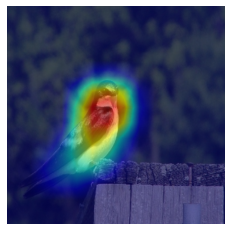

In [309]:
pretrain_path2 = 'EIE_visual_rs50.pth'
model_vm2 = model_visual2(pretrain_path2)
target_layer = model_vm2.model.layer4[-1].conv3
input_tensor = inputs # Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam2 = GradCAM(model=model_vm2 , target_layer=target_layer, use_cuda=True)

# If target_category is None, the highest scoring category
# will be used for every image in the batch.
# target_category can also be an integer, or a list of different integers
# for every image in the batch.
target_category = 281

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam2 = cam2(input_tensor=input_tensor, target_category=None)
grayscale_cam2 = cam2(input_tensor=input_tensor, target_category=None, aug_smooth=True, eigen_smooth=True)
# In this example grayscale_cam has only one image in the batch:
grayscale_cam2 = grayscale_cam2[0, :]
rgb_image2 = inputs.view(3, 448, 448)
rgb_image2 = rgb_image2.permute(1, 2, 0).numpy()
visualization2 = show_cam_on_image(rgb_image2, grayscale_cam2, use_rgb=True)

plt.axis('off')
plt.imshow(visualization2)
plt.savefig('EX4_output/Tree_Swallow_0090_135325_EIE.jpg', bbox_inches='tight', pad_inches=0)